# Gaussian Mixture Models

This is a notebook showing how to use Scikit's [Gaussian Mixture Model (GMM)](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture).

## Motivation, A Simple Example

Oftentimes, you see observations and you want to understand the distributions from which they came. Let's make it simple and say you observe the lengths of left arms. Now, these lengths may come from a child (age < 18) or an adult (age >= 18); however, you do not know that there are indeed two populations (children and adults). If you perform a density plot the lengths, you will most likely observe a multi-modal distribution (one for the children and the other for the adults). If you simply assume a single gaussian distribution, you would be wrong. GMMs assume that the distribution you are seeing actually comes from multiple underlying guassian distributions that are "mixing" to produce what you see. 

## The Data, Arm Lengths

Let's start out by looking at the data. First, these are real data from children and adults at [One-Off Coder](https://www.oneoffcoder.com). Second, although we know that the data comes from two different population, we are going to pretend as if we only observe the arm lengths.

In [1]:
import numpy as np
import pandas as pd

# these are the arm lengths
# a is for adult
# c is child
a_lengths = np.array([24, 23.5, 25.5, 22.0, 25.5, 25.5, 24.0, 28.0, 24.5])
c_lengths = np.array([24.0, 23.0, 21.0, 15.5, 17.5, 17.5, 19.0, 17.0, 17.0, 27.0])

# these are the corresponding labels
# children are marked as 0
# adults are marked as 1
a_labels = np.ones(a_lengths.shape[0], dtype=int)
c_labels = np.zeros(c_lengths.shape[0], dtype=int)

# these are the natural corresponding labels
a_nlabels = ['adult' for _ in range(a_lengths.shape[0])]
c_nlabels = ['child' for _ in range(c_lengths.shape[0])]

# we build a pandas dataframe from the data
lengths = np.concatenate([c_lengths, a_lengths])
labels = np.concatenate([c_labels, a_labels])
nlabels = np.concatenate([c_nlabels, a_nlabels])
df = pd.DataFrame({ 'length': lengths, 'label': labels, 'nlabel': nlabels})

In [2]:
df

,length,label,nlabel
0,24.0,0,child
1,23.0,0,child
2,21.0,0,child
3,15.5,0,child
4,17.5,0,child
5,17.5,0,child
6,19.0,0,child
7,17.0,0,child
8,17.0,0,child
9,27.0,0,child


## Visualize the Data

Now, we plot the distributions. There is a one for children and adults, and another one for all of the children and adults together. As you can see, when all the data is plotted together, there are two "humps". This data (with all the children and adult arm lengths lumped together) is what we pretend we are seeing.

### Distribution Plots

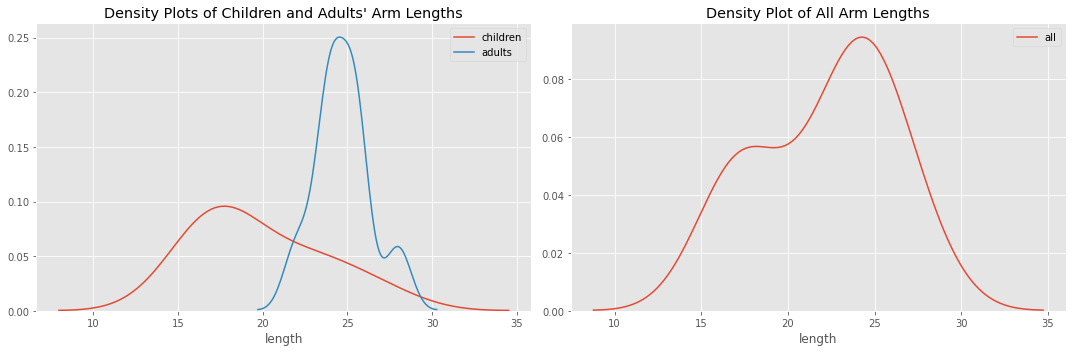

In [3]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.distplot(df[df['label'] == 0]['length'], label='children', hist=False, ax=ax1)
sns.distplot(df[df['label'] == 1]['length'], label='adults', hist=False, ax=ax1)
sns.distplot(df['length'], label='all', hist=False, ax=ax2)
ax1.set_title('Density Plots of Children and Adults\' Arm Lengths')
ax2.set_title('Density Plot of All Arm Lengths')

plt.tight_layout()

### Box and Swarm Plots

Here are some box and swarm plots to see if we can visually detect outliers. As you can see, there is tremendous variance in the children population while the adults are very tight. 

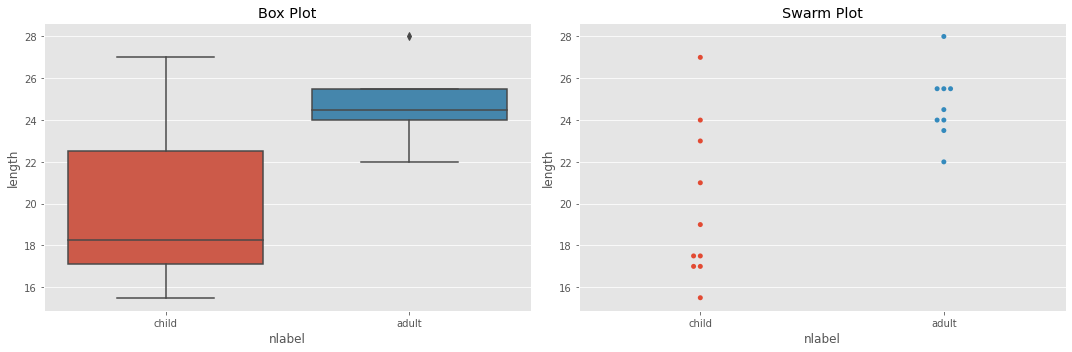

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x='nlabel', y='length', data=df, ax=ax[0])
sns.swarmplot(x='nlabel', y='length', data=df, ax=ax[1])
ax[0].set_title('Box Plot')
ax[1].set_title('Swarm Plot')
plt.tight_layout()

## Data Science

In GMMs, we want to understand and recover the underlying, "mixing" or "hidden" distributions. Since we do not directly observe these distributions and only hypothesize that they exists, these distributions are often referred to as "hidden" or "latent". Again, we do not even know how many hidden gaussian distributions there are! When we apply GMMs to a dataset to understand and recover its underlying distributions, we typically have to "guess" the number of such distributions before hand. Typically, we would guess that there are 2, 3, 4, and so on, underlying distributions. At each step, we might apply a "goodness of fit" test to see how well the models (with 2, 3, 4, ... assumed hidden gaussians) fit the data and pick the best fitting one. 

### k-means clustering

In this notebook, we avoid completely "guessing" the number of hidden gaussians by using [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) to identify how many hidden gaussians might actually be in the data. We start out by assuming 2, 3, ..., 10 clusters in the data; in the example, this assumption means that the lengths we are seeing comes from 2, 3, ..., 10 different groups. We use the [silhouette score](https://en.wikipedia.org/wiki/Silhouette_%28clustering%29) to determine which k is the best and use that k to create and learn a GMM.

Let's use k-means to see how many clusters are in the population. Remember, pretend like you do not know how many clusters (or populations) are in the cluster. We will set k to 2, 3, ..., 10 and see which number of clusters (according to the silhouette score) is the best. As you can see below, k=2 is the best. Additionally, we plot the score of the GMM model corresponding to each k. A higher silhouette score indicates a better fit and a lower GMM score indicates a better fit.

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

def get_silhouette_score(X, k):
    model = KMeans(k, random_state=37)
    model.fit(X)
    labels = model.predict(X)
    score = silhouette_score(X, labels)
    return score

def get_gmm_score(X, k):
    gmm = GaussianMixture(n_components=k, max_iter=50)
    gmm.fit(X)
    gmm_scores = gmm.score_samples(X)
    score = np.exp(gmm_scores).sum()
    return score

def get_scores(X, k):
    return k, get_silhouette_score(X, k), get_gmm_score(X, k)

X = df['length'].values.reshape(-1, 1)

score_df = pd.DataFrame([get_scores(X, k) for k in range(2, 11, 1)], columns=['k', 'sil', 'gmm'])

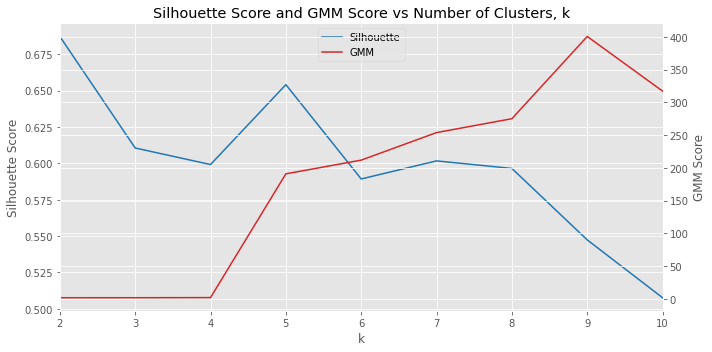

In [6]:
fig, ax1 = plt.subplots(figsize=(10, 5))

k_min = np.min(score_df['k'])
k_max = np.max(score_df['k'])

line1 = ax1.plot(score_df['k'], score_df['sil'], color='tab:blue', label='Silhouette')
ax2 = ax1.twinx()
line2 = ax2.plot(score_df['k'], score_df['gmm'], color='tab:red', label='GMM')

lines = line1 + line2
labels = [l.get_label() for l in lines]

ax1.set_title('Silhouette Score and GMM Score vs Number of Clusters, k')
ax1.legend(lines, labels, loc=9)
ax1.set_xlabel('k')
ax1.set_ylabel('Silhouette Score')
ax1.set_xlim([k_min, k_max])
ax2.set_ylabel('GMM Score')

fig.tight_layout()

### GMM

So we have determined that k=2 produces the best clustering of the data. Thus, we will assume that there are 2 mixing guassian distributions. Below, we use k=2 to learn a GMM model. 

Note that when a GMM learns the parameters for the hidden distributions, it will randomly assign 0, 1, 2, ... as a label to each one, and these labels will have nothing to do with how you labeled the data (in our case, 0 = child, 1 = adult). In this experiment, GMM assigned 0 for the distribution that we already know is representative of adults and 1 for the distribution we already know is representative of children (that is why we reverse them). In the real world, you will have to deal with the random labelling of these hidden distributions and use your domain knowledge to interpret what these labels represent.

In [7]:
def get_kmeans_labels(X, k):
    model = KMeans(k, random_state=37)
    model.fit(X)
    labels = model.predict(X)
    labels = np.array([0 if label == 1 else 1 for label in labels])
    return labels, model

def get_gmm_labels(X, k):
    gmm = GaussianMixture(n_components=k, max_iter=50, random_state=37)
    gmm.fit(X)
    labels = gmm.predict(X)
    labels = np.array([0 if label == 1 else 1 for label in labels])
    return labels, gmm

prediction_df = df.copy()

best_k = int(score_df.sort_values(['sil'], ascending=False).iloc[0]['k'])
prediction_df['kms_label'], kms = get_kmeans_labels(X, best_k)
prediction_df['gmm_label'], gmm = get_gmm_labels(X, best_k)
print('best k = {}'.format(best_k))

best k = 2


In [8]:
prediction_df

,length,label,nlabel,kms_label,gmm_label
0,24.0,0,child,0,0
1,23.0,0,child,0,0
2,21.0,0,child,1,0
3,15.5,0,child,1,1
4,17.5,0,child,1,1
5,17.5,0,child,1,1
6,19.0,0,child,1,1
7,17.0,0,child,1,1
8,17.0,0,child,1,1
9,27.0,0,child,0,0


### GMM Results Visualized

Here is the result of clustering and GMM model's prediction visualized.

cluster=0, color=(0.0, 0.0, 1.0, 1.0)
cluster=1, color=(1.0, 0.0, 0.0, 1.0)


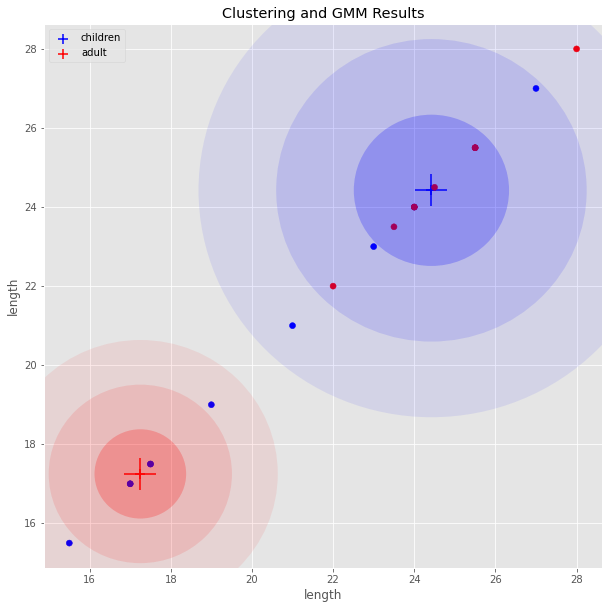

In [9]:
import matplotlib.colors as colors
from matplotlib.patches import Ellipse

fig, ax = plt.subplots(figsize=(10, 10))
colorset = ['blue', 'red']

pcs = []
for cluster, label in zip(range(best_k), ['children', 'adults']):
    cluster_df = prediction_df[prediction_df['gmm_label'] == cluster]
    mu = cluster_df.mean().loc['length']
    cov = cluster_df.var().loc['length']
    cov = np.array([[cov]])
    
    eva, eve = np.linalg.eigh(cov)
    order = eva.argsort()[::-1]
    eva, eve = eva[order], eve[:, order]
    vx, vy = eve[:,0][0], eve[:,0][0]
    theta = np.arctan2(vy, vx)
    color = colors.to_rgba(colorset[cluster])
    print('cluster={}, color={}'.format(cluster, color))
    
    for cov_factor in range(1, 4):
        size = np.sqrt(eva[0]) * cov_factor * 2
        angle = np.degrees(theta)
        ell = Ellipse(
            xy=(mu, mu), 
            width=size, 
            height=size, 
            angle=angle, 
            linewidth=2)
        ell.set_facecolor((color[0], color[1], color[2], 1.0 / (cov_factor * 4.5)))
        ax.add_artist(ell)
    
    c = [colorset[v] for v in cluster_df['label'].values]
    pc = ax.scatter(mu, mu, marker='+', s=100, c=colorset[cluster])
    ax.scatter(mu, mu, marker='+', s=1000, c=colorset[cluster])
    ax.scatter(cluster_df['length'], cluster_df['length'], label=label, c=c, marker='o')
    pcs.append(pc)
    
ax.set_title('Clustering and GMM Results')
ax.set_xlabel('length')
ax.set_ylabel('length')
ax.legend(pcs, ['children', 'adult'])

### GMM Performances

So how well did the GMM model do? 

In [10]:
prediction_df = pd.concat([prediction_df, pd.DataFrame(gmm.predict_proba(X), columns=['gmm_1', 'gmm_0'])], axis=1)
prediction_df

,length,label,nlabel,kms_label,gmm_label,gmm_1,gmm_0
0,24.0,0,child,0,0,2.706874e-10,1.000000
1,23.0,0,child,0,0,1.380768e-07,1.000000
2,21.0,0,child,1,0,4.759825e-03,0.995240
3,15.5,0,child,1,1,9.999280e-01,0.000072
4,17.5,0,child,1,1,9.984682e-01,0.001532
5,17.5,0,child,1,1,9.984682e-01,0.001532
6,19.0,0,child,1,1,9.184310e-01,0.081569
7,17.0,0,child,1,1,9.994453e-01,0.000555
8,17.0,0,child,1,1,9.994453e-01,0.000555
9,27.0,0,child,0,0,3.613962e-20,1.000000


This the precision, recall and f1-score for the GMM model.

In [11]:
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(prediction_df['label'], prediction_df['gmm_label']))

              precision    recall  f1-score   support

           0       0.31      0.40      0.35        10
           1       0.00      0.00      0.00         9

    accuracy                           0.21        19
   macro avg       0.15      0.20      0.17        19
weighted avg       0.16      0.21      0.18        19



This is the precision, recall, and f1-score for the kmeans model.

In [12]:
print(classification_report(prediction_df['label'], prediction_df['kms_label']))

              precision    recall  f1-score   support

           0       0.25      0.30      0.27        10
           1       0.00      0.00      0.00         9

    accuracy                           0.16        19
   macro avg       0.12      0.15      0.14        19
weighted avg       0.13      0.16      0.14        19



This is the ROC AUC score for the GMM model.

In [13]:
roc_auc_score(prediction_df['label'], prediction_df['gmm_1'])

0.1333333333333333

In [14]:
# the means learned from GMM
print(gmm.means_)

# the empirical means from the data
print(df[df['label'] == 0]['length'].mean())
print(df[df['label'] == 1]['length'].mean())

[[17.23018165]
 [24.38989552]]
19.85
24.72222222222222


### Cross validation

Note that these results are not validated with a holdout set but rather with the training data itself. Let's do a simple [leave-one-out](https://en.wikipedia.org/wiki/Cross-validation_%28statistics%29%23Leave-one-out_cross-validation) (LOO) validation. LOO validation is where we keep 1 example out, learn a model from the rest, and then use that learned model to make a prediction on the 1 example we left out; this procedure is repeated N times for N data points and we average out the performances over N.

In [15]:
from sklearn.model_selection import LeaveOneOut

X = df['length'].values.reshape(-1, 1)
y = df['label'].values

loo = LeaveOneOut()
N = loo.get_n_splits(X)
t = 0

for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    score_df = pd.DataFrame([(k, get_silhouette_score(X, k)) for k in range(2, 11, 1)], columns=['k', 'sil'])
    best_k = int(score_df.sort_values(['sil'], ascending=False).iloc[0]['k'])
    
    gmm = GaussianMixture(n_components=best_k, max_iter=50, random_state=37)
    gmm.fit(X_train, y_train)
    
    y_true = y_test[0]
    y_pred = [0 if p == 1 else 1 for p in gmm.predict(X_test)][0]
    t = t + (1 if y_true == y_pred else 0)
    
accuracy = t / N
print('LOO accuracy is {:.5f}'.format(accuracy))

LOO accuracy is 0.21053


Note that the LOO accuracy (simply the number of matches of prediction to true labels) is not that bad. It's at 79% percent. 